# Using DS9 Regions to Include and Exclude Sources in HST Image Alignment with TWEAKREG

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

<a id='top'></a>

## Introduction

DS9 is a popular [image visualization program](http://ds9.si.edu/site/Home.html) used in astronomy. It is now a standard package in the [AstroConda channel](https://astroconda.readthedocs.io/en/latest/). DS9 regions are interactive, user generated shapes which mark areas of interest. [Here is documentation](http://ds9.si.edu/doc/ref/region.html) about DS9 regions. For users with no experience with DS9, many resources exist online. One example is [this AstroBites page](https://astrobites.org/2011/03/09/how-to-use-sao-ds9-to-examine-astronomical-images/) which summarizes the most common DS9 features. 

In this example we show how [TweakReg](https://drizzlepac.readthedocs.io/en/latest/tweakreg.html) can include and exclude sources identified by DS9 regions during image alignment. The use of "excluded" regions prevents spurious detections and ignores parts of the input images that might trouble a proper identification of sources for alignment. "Included" regions is particularly useful for images that have few good sources that can be used for image alignment and need all other sources not contained within these regions to be ignored. 

This notebook is based on a [prior example](http://www.stsci.edu/hst/HST_overview/drizzlepac/examples/example10) available from the [DrizzlePac webpage](http://www.stsci.edu/hst/HST_overview/drizzlepac). Please direct inquires about this notebook, DrizzlePac, or any other issues with HST images to the [HST help desk](https://stsci.service-now.com/hst).

In [1]:
# import all packages
import glob
import os
import shutil

from astropy.table import Table
from astropy.io import fits
from astroquery.mast import Observations
from drizzlepac import tweakreg
import matplotlib.pyplot as plt
from photutils import CircularAperture
import regions
from regions import read_ds9

# set plotting details for notebooks
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,20)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


## 1. Download the data

This example uses observations of 'MACSJ1149.5+2223-HFFPAR' ([proposal ID 13504](http://www.stsci.edu/cgi-bin/get-proposal-info?id=13504&observatory=HST), files `jcdua3f4q_flc.fits` and `jcdua3f8q_flc.fits`). We provide code below to retrieve the ACS/WFC calibrated FLC files. 

Data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu/) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST.

It is unusual to download individual files instead of all the related files in an association, but it can be done. First, we need to find the IDs for these two specific FLC files. 

**Note:** `astroquery` uses both `obs_id` and `obsID`. Be careful not to confuse them. 

In [2]:
# Retrieve the observation information.
obs_table = Observations.query_criteria(obs_id=['JCDUA3010','JCDUA3020'])

# Find obsID for specific FLC images.
product_list_by_association = Observations.get_product_list(obs_table['obsid'])
product_list_by_association['obsID', 'productFilename'][18:28]

obsID,productFilename
str10,str23
2003170978,jcdua3f4q_flc.fits
2003170978,jcdua3f4q_flt_hlet.fits
2003170978,jcdua3f4q_spt.fits
2003170978,jcdua3f4q_trl.fits
2003170978,jcdua3f4q_raw.jpg
2003170978,jcdua3f4q_flc.jpg
2003170978,jcdua3f4q_flt.jpg
2003170978,jcdua3f4q_flt.fits
2003170978,jcdua3f4q_raw.fits


Based on this table, the `obsID` values for `jcdua3f4q_flc.fits` and `jcdua3f8q_flc.fits` are 2003170978 and 2003170979. We use this information to download these two FITS files. 

In [3]:
# Download jcdua3f4q_flc.fits and jcdua3f8q_flc.fits from MAST. 
dataProductsByID = Observations.get_product_list(['2003170978','2003170979'])
dataProductsByID = Observations.filter_products(dataProductsByID, 
                                                productSubGroupDescription='FLC')
download_table = Observations.download_products(dataProductsByID)

 [Done]


 [Done]


**If the cell above produces an error, try running it again.** Connection issues can cause errors on the first try. 

In [4]:
# Move the files from the mastDownload directory to the current working directory.
fits_files = glob.glob('mastDownload/HST/*/jcdua3f[48]q_flc.fits') 
for file in fits_files:
    os.rename(file, os.path.basename(file))
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

## 2. Use TweakReg to create source catalogs



Run `TweakReg` on one of the FLC files downloaded into this directory, `jcdua3f4q_flc.fits`. By limiting the input list to one file `TweakReg` makes the source catalog for this image, but performs no matching or aligning. Using a slightly larger `conv_width` of 4.5 pixels (versus the default of 3.5 for ACS/WFC) means `TweakReg` will be able to utilize small compact objects for alignment. 

**Note**: This notebook is only concerned with the source detection capabilities of `TweakReg`, and so to prevent any changes being saved to the images, the `updatehdr` parameter is set to **False**. 

In [5]:
tweakreg.TweakReg('jcdua3f4q_flc.fits', 
                  imagefindcfg=dict(threshold=50,conv_width=4.5),
                  updatehdr=False)

Setting up logfile :  tweakreg.log


TweakReg Version 1.4.7(18-April-2018) started at: 14:30:49.252 (30/04/2019) 


Version Information


--------------------


Python Version [GCC 7.3.0]


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


numpy Version -> 1.15.4 


astropy Version -> 3.1.2 


stwcs Version -> 1.4.2 


Finding shifts for: 


    jcdua3f4q_flc.fits


===  Source finding for image 'jcdua3f4q_flc.fits':


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 1) started at: 14:30:49.384 (30/04/2019)


     Found 10294 objects.


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 2) started at: 14:30:50.49 (30/04/2019)


     Found 10502 objects.


===  FINAL number of objects in image 'jcdua3f4q_flc.fits': 20796


Trailer file written to:  tweakreg.log


This creates four output files:
- *jcdua3f4q_flc_sci1_xy_catalog.coo* contains the X and Y positions, flux, and IDs for all detected sources in the SCI1 extention 
- *jcdua3f4q_flc_sci2_xy_catalog.coo* contains the X and Y positions, flux, and IDs for all detected sources in the SCI2 extention
- *jcdua3f4q_flc_sky_catalog.coo* has the RA and DEC of all the sources from both extensions 
- *tweakreg.log* is the log file output from `TweakReg`

Read in the the SCI1 catalog file. 

In [6]:
# Read in the SCI1 catalog file
coords_tab = Table.read('jcdua3f4q_flc_sci1_xy_catalog.coo', 
                        format='ascii.no_header', names=['X','Y','Flux', 'ID'])

# Output the first five rows to display the table format
coords_tab[0:5]

X,Y,Flux,ID
float64,float64,float64,int64
486.985,3.91541,6331.84,0
2079.0,3.93373,7009.1,1
3365.99,4.92486,6260.46,2
2935.1,5.00039,10549.2,3
471.273,5.04839,24463.9,4


Now read in the FITS image. This step will be used for demonstrative plots and is not necessary to run `TweakReg`.

In [7]:
hdulist = fits.open('jcdua3f4q_flc.fits')

Then use `photutils` to generate apertures in order to display the source catalog positions detected by `TweakReg` on the FITS image. A fair number of spurious detections are found, but these are generally cosmic-rays which fall in random positions across the detector and will therefore not make it through into the matched catalogs (frame to frame). 

**Note**: This step may take a few seconds to run due to the large number of apertures plotted.

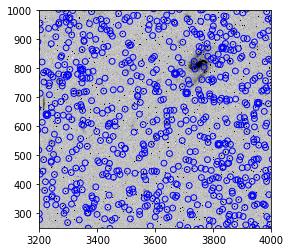

In [8]:
# Make the apertures with photutils. 
# One pixel offset corrects for differences between (0,0) and (1,1) origin systems. 
apertures = CircularAperture([coords_tab['X']-1., 
                              coords_tab['Y']-1.], 
                              r=10.)

# Plot a region of the image with pyplot
plt.imshow(hdulist[1].data, cmap='Greys', origin='lower', vmin=0, vmax=400)
plt.axis([3200,4000,250,1000])

# Overplot the apertures onto the image
apertures.plot(color='blue', lw=1)

## 3. DS9 Regions in TweakReg

`TweakReg` allows the following DS9 regions: circle, ellipse, polygon, and box. All other regions are ignored. All region files must comply with the DS9 region file format and all regions must be provided in *image* coordinates.

This demonstration uses one of each type of shape possible. In the region file, they look like this (in image coordinates): 

```ds9
polygon(3702,845,3819,890,3804,797,3734,720,3671,745,3592,735,3602,770,3660,782)
ellipse(3512,809,26,67,0)
circle(3613,396,75)
box(3541,393,113,96,0)
```

Next the DS9 regions are read in and parsed with the [astropy regions package](https://astropy-regions.readthedocs.io/en/latest/getting_started.html) and then added to the plot to show how they look on the image. 

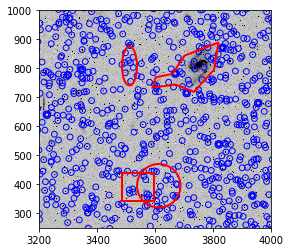

In [9]:
# Read in and parse the DS9 region file with the regions package
ds9_regions_file = 'jcdua3f4q_sci1_exclude.reg'
regions = read_ds9(ds9_regions_file, errors='ignore')

# Plot previous figure with DS9 region shapes
fig, ax = plt.subplots()
ax.imshow(hdulist[1].data, 
          cmap='Greys', 
          origin='lower', 
          vmin=0, vmax=400)
ax.axis([3200,4000,250,1000])
apertures.plot(color='blue', lw=1.)
for regs in range(4):
    regions[regs].plot(ax=ax, edgecolor='red', lw=2, fill=False)
plt.show()

You can see the polygon outlining a galaxy, including the extended tidal stream. The other shapes are placed randomly as demonstration.

This figure will be remade several times with different `TweakReg` outputs, so a function has been defined below to automatically read in the TweakReg source catalog and reproduce this figure.

In [10]:
# Define a function to remake this figure after subsequent TweakReg runs.
def read_tweak_cat_and_plot():
    '''
    This function reads in the TweakReg coordinate catalog for
    SCI1 of image JCDUA3F4Q, creates apertures for all the sources
    detected, then plots the apertures on the FITS image along
    with the DS9 region files defined previously in the notebook.'''

    # Read in the SCI1 catalog file with the exclusions
    coords_tab = Table.read('jcdua3f4q_flc_sci1_xy_catalog.coo', 
                            format='ascii.no_header', 
                            names=['X','Y','Flux', 'ID'])
    # Define apertures for TweakReg identified sources
    apertures = CircularAperture([coords_tab['X']-1., 
                                  coords_tab['Y']-1.], 
                                  r=10.)
    # Plot
    fig, ax = plt.subplots()
    ax.imshow(hdulist[1].data, cmap='Greys', 
              origin='lower', vmin=0, vmax=400)
    ax.axis([3200,4000,250,1000])
    apertures.plot(color='blue', lw=1.)
    for regs in range(4):
        regions[regs].plot(ax=ax, edgecolor='red', lw=2, fill=False)
    plt.show()

## 4. Exclusion regions

`TweakReg` identifies the DS9 region files from a plain text file provided to the `exclusions` parameter. This text file must give the filename of the images and the name of the DS9 region files that should be applied to the SCI1 and SCI2 extensions, respectively. The format is important, and for our example would look like:

```
jcdua3f4q_flc.fits jcdua3f4q_sci1_exclude.reg None
jcdua3f8q_flc.fits None None
```

'None' serves the function of an empty placeholder. Since the exclusions are applied only to SCI1, the syntax can be simplified to the following. 

```
jcdua3f4q_flc.fits jcdua3f4q_sci1_exclude.reg
jcdua3f8q_flc.fits
```

**NOTE**: If an image needs DS9 regions applied to the SCI2 extension only, then 'None' **must** be written after the filename and before the SCI2 region.  

The git repo for this notebook contains a file `exclusions.txt` to use as input to `TweakReg`. 

To exclude the sources within a DS9 region shape, a minus sign (-) is put before the shape. This time, all four shapes will be exluded from source detection. The corresponding DS9 region `jcdua3f4q_sci1_exclude.reg` therefore has the syntax:

```ds9
# Region file format: DS9 version 4.1
global color=yellow dashlist=8 3 width=2 font="helvetica 10 normal roman" 
select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
-polygon(3702,845,3819,890,3804,797,3734,720,3671,745,3592,735,3602,770,3660,782)
-ellipse(3512,809,26,67,0)
-circle(3613,396,75)
-box(3541,393,113,96,0)
```

Now `TweakReg` is run again, this time with the DS9 regions provided by the `exclusions` parameter.

In [11]:
# tweakreg run with DS9 regions excluded from source detection
tweakreg.TweakReg('jcdua3f4q_flc.fits', 
                  imagefindcfg=dict(threshold=50,conv_width=4.5),
                  exclusions='exclusions.txt',
                  updatehdr=False)

Setting up logfile :  tweakreg.log


TweakReg Version 1.4.7(18-April-2018) started at: 14:31:14.869 (30/04/2019) 


Version Information


--------------------


Python Version [GCC 7.3.0]


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


numpy Version -> 1.15.4 


astropy Version -> 3.1.2 


stwcs Version -> 1.4.2 


jcdua3f4q_flc.fits


jcdua3f8q_flc.fits


Finding shifts for: 


    jcdua3f4q_flc.fits


===  Source finding for image 'jcdua3f4q_flc.fits':


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 1) started at: 14:31:15.009 (30/04/2019)


     Found 10233 objects.


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 2) started at: 14:31:17.549 (30/04/2019)


     Found 10502 objects.


===  FINAL number of objects in image 'jcdua3f4q_flc.fits': 20735


Trailer file written to:  tweakreg.log


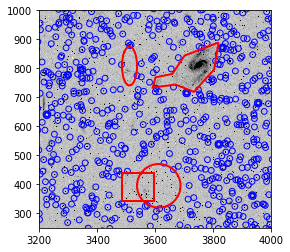

In [12]:
read_tweak_cat_and_plot()

As expected, sources within the defined DS9 exlusion regions are no longer in the `TweakReg` source catalog. 

## 5. Inclusion Regions

Now we will look at inclusions, where only sources inside the DS9 regions are detected by `TweakReg`. The `exclusions` parameter name doesn't change, but in this example we give it `inclusions.txt` now instead. 

```
jcdua3f4q_flc.fits jcdua3f4q_sci1_include.reg
jcdua3f8q_flc.fits
```

From the information from the last section, the file syntax indicates that `jcdua3f4q_sci1_include.reg` is applied to the SCI1 extention of `jcdua3f4q_flc.fits`, and no DS9 regions are given for the SCI2 extention, or for the second image `jcdua3f8q_flc.fits`. 

Looking at `jcdua3f4q_sci1_include.reg`, it shows the same shapes as before, but the minus signs (-) at the beginning of the lines are removed. 

```ds9
# Region file format: DS9 version 4.1
global color=yellow dashlist=8 3 width=2 font="helvetica 10 normal roman" 
select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
polygon(3702,845,3819,890,3804,797,3734,720,3671,745,3592,735,3602,770,3660,782)
ellipse(3512,809,26,67,0)
circle(3613,396,75)
box(3541,393,113,96,0)
```

There is no symbol associated with inclusion regions. If there is no symbol before the shape, then it is treated as an inclusion region. If there is a minus sign (-), then it is treated as an exclusion region. 

In [13]:
# tweakreg run with source detection only inside the DS9 regions 
tweakreg.TweakReg('jcdua3f4q_flc.fits', 
                  imagefindcfg=dict(threshold=50,conv_width=4.5),
                  exclusions='inclusions.txt',
                  updatehdr=False)

Setting up logfile :  tweakreg.log


TweakReg Version 1.4.7(18-April-2018) started at: 14:31:29.939 (30/04/2019) 


Version Information


--------------------


Python Version [GCC 7.3.0]


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


numpy Version -> 1.15.4 


astropy Version -> 3.1.2 


stwcs Version -> 1.4.2 


jcdua3f4q_flc.fits


jcdua3f8q_flc.fits


Finding shifts for: 


    jcdua3f4q_flc.fits


===  Source finding for image 'jcdua3f4q_flc.fits':


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 1) started at: 14:31:30.073 (30/04/2019)


     Found 63 objects.


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 2) started at: 14:31:31.485 (30/04/2019)


     Found 10502 objects.


===  FINAL number of objects in image 'jcdua3f4q_flc.fits': 10565


Trailer file written to:  tweakreg.log


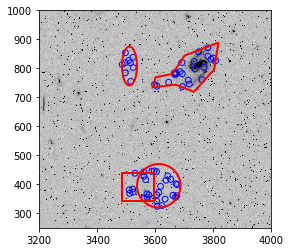

In [14]:
read_tweak_cat_and_plot()

This shows that only sources in the DS9 regions are included in the `TweakReg` source catalog. Note that only 63 objects were found by `TweakReg` for SCI1, compared to 10294 found in the original catalog. The number of objects for SCI2 is unchanged. 

## 6. Combining Exclusion and Inclusion Regions

The inclusion and exclusion regions can be used at the same time. For this example, the `inclusions_no_box.txt` file is fed to the exclusions parameter in `TweakReg`. 

```
jcdua3f4q_flc.fits jcdua3f4q_sci1_include_no_box.reg
jcdua3f8q_flc.fits
```

`jcdua3f4q_sci1_include_no_box.reg` has only a minus sign (-) on the last line. 

```ds9
# Region file format: DS9 version 4.1
global color=yellow dashlist=8 3 width=2 font="helvetica 10 normal roman" 
select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
polygon(3702,845,3819,890,3804,797,3734,720,3671,745,3592,735,3602,770,3660,782)
ellipse(3512,809,26,67,0)
circle(3613,396,75)
-box(3541,393,113,96,0)
```

This means that all the shapes will be treated as inclusion regions except for the box, which will be excluded from the source detection. 

In [15]:
# tweakreg run with a mix of included/excluded DS9 regions
tweakreg.TweakReg('jcdua3f4q_flc.fits', 
                  imagefindcfg=dict(threshold=50,conv_width=4.5),
                  exclusions='inclusions_no_box.txt',
                  updatehdr=False)

Setting up logfile :  tweakreg.log


TweakReg Version 1.4.7(18-April-2018) started at: 14:31:33.779 (30/04/2019) 


Version Information


--------------------


Python Version [GCC 7.3.0]


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


numpy Version -> 1.15.4 


astropy Version -> 3.1.2 


stwcs Version -> 1.4.2 


jcdua3f4q_flc.fits


jcdua3f8q_flc.fits


Finding shifts for: 


    jcdua3f4q_flc.fits


===  Source finding for image 'jcdua3f4q_flc.fits':


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 1) started at: 14:31:33.925 (30/04/2019)


     Found 51 objects.


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 2) started at: 14:31:35.299 (30/04/2019)


     Found 10502 objects.


===  FINAL number of objects in image 'jcdua3f4q_flc.fits': 10553


Trailer file written to:  tweakreg.log


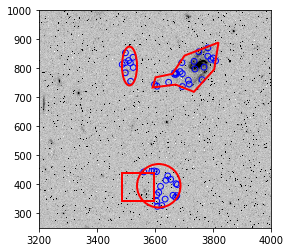

In [16]:
read_tweak_cat_and_plot()

This shows the sources detected within the inclusion regions except for those excluded from the box. 

**NOTE**: The order of the DS9 regions is important! 

`TweakReg` applies the DS9 region requirements in the order in which they appear in the DS9 region file. To demonstrate this, the excluded box shape is moved to the beginning of the region list, so that it is the first processed instead of the last. This is seen by inputing `inclusions_no_box_first.txt` which specifies the region file `jcdua3f4q_sci1_include_no_box_first.reg`:

```ds9
# Region file format: DS9 version 4.1
global color=yellow dashlist=8 3 width=2 font="helvetica 10 normal roman" 
select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
-box(3541,393,113,96,0)
polygon(3702,845,3819,890,3804,797,3734,720,3671,745,3592,735,3602,770,3660,782)
ellipse(3512,809,26,67,0)
circle(3613,396,75)
```

In [17]:
# tweakreg run with excluded box first to show order of operations
tweakreg.TweakReg('jcdua3f4q_flc.fits', 
                  imagefindcfg=dict(threshold=50,conv_width=4.5),
                  exclusions='inclusions_no_box_first.txt',
                  updatehdr=False)

Setting up logfile :  tweakreg.log


TweakReg Version 1.4.7(18-April-2018) started at: 14:31:37.123 (30/04/2019) 


Version Information


--------------------


Python Version [GCC 7.3.0]


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


numpy Version -> 1.15.4 


astropy Version -> 3.1.2 


stwcs Version -> 1.4.2 


jcdua3f4q_flc.fits


jcdua3f8q_flc.fits


Finding shifts for: 


    jcdua3f4q_flc.fits


===  Source finding for image 'jcdua3f4q_flc.fits':


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 1) started at: 14:31:37.342 (30/04/2019)


     Found 58 objects.


  #  Source finding for 'jcdua3f4q_flc.fits', EXT=('SCI', 2) started at: 14:31:38.675 (30/04/2019)


     Found 10502 objects.


===  FINAL number of objects in image 'jcdua3f4q_flc.fits': 10560


Trailer file written to:  tweakreg.log


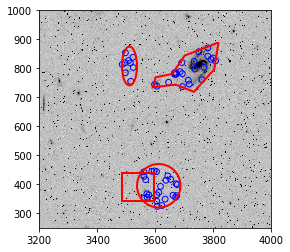

In [18]:
read_tweak_cat_and_plot()

Now the circle is given precedence because it is the last region shape processed, and therefore the section of overlap with the box is not removed as it was in the previous figure. 

Due to this behavior, **remember to be careful with the order in the DS9 region file when combining inclusion and exclusion requirements.**

# About this Notebook

    Author: S. Hoffmann, STScI ACS Team  
    Updated: December 14, 2018  

[Top of Page](#top)